Objective

Fashion-MNIST is a dataset of Zalando's article images —consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label.

The objective of the project is - to use Fashion-MNIST data set to identify (predict) different fashion products(articles) from the given images using Machine Learning.

We will be following the below steps to solve this problem:

1.Importing the libraries

2.Using some pre-defined utility functions

3.Loading the data

4.Cleaning the data

5.Dividing the dataset into training and test dataset using train_test_split in the ratio 85:15

6.Training several models and analyzing their performance to select a model

7.Use dimensionality reduction to improve the ‘training’,
‘fine-tuning’ and ‘prediction’ time.

8.Fine-tuning the model by finding the best hyper-parameters and features

9.Evaluating selected model using test dataset


1.Importing the libraries
    To start with the code, we would need some libraries. Please import the same into the environment

In [26]:
import numpy as np
import pandas as pd
import gzip
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

2.Using some pre-defined utility functions
    The showImage() function given below displays the input dataset instance (image) on the screen

In [27]:


def showImage(data):
    some_article = data   # Selecting the image.
    some_article_image = some_article.reshape(28, 28) # Reshaping it to get the 28x28 pixels
    plt.imshow(some_article_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

3.Loading the data
    Let us load the Fashion MNIST dataset (this dataset is copied from Zalando Research repository)

In [28]:
import requests
import gzip
import numpy as np
from io import BytesIO  # Note: Correct capitalization

# Correct URLs (fixed typos in filenames)
train_images_url = "https://raw.githubusercontent.com/arpitmishra447/projects/master/fashion%20mnist/Dataset/train-images-idx3-ubyte.gz"
train_labels_url = "https://raw.githubusercontent.com/arpitmishra447/projects/master/fashion%20mnist/Dataset/train-labels-idx1-ubyte.gz"
test_images_url = "https://raw.githubusercontent.com/arpitmishra447/projects/master/fashion%20mnist/Dataset/t10k-images-idx3-ubyte.gz"
test_labels_url = "https://raw.githubusercontent.com/arpitmishra447/projects/master/fashion%20mnist/Dataset/t10k-labels-idx1-ubyte.gz"

def load_data(url):
    response = requests.get(url)
    response.raise_for_status()
    return BytesIO(response.content)

# Load all files
filePath_train_set = load_data(train_images_url)
filePath_train_label = load_data(train_labels_url)
filePath_test_set = load_data(test_images_url)
filePath_test_label = load_data(test_labels_url)

def parse_images(f):
    with gzip.open(f, 'rb') as file:
        # Read magic number (first 4 bytes)
        magic = int.from_bytes(file.read(4), 'big')
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} for images")

        # Read dimensions (next 12 bytes)
        num_images = int.from_bytes(file.read(4), 'big')
        rows = int.from_bytes(file.read(4), 'big')
        cols = int.from_bytes(file.read(4), 'big')

        # Read image data
        data = np.frombuffer(file.read(), dtype=np.uint8)
        return data.reshape(num_images, rows * cols)  # Flatten to 784 (28x28)

def parse_labels(f):
    with gzip.open(f, 'rb') as file:
        # Read magic number (first 4 bytes)
        magic = int.from_bytes(file.read(4), 'big')
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} for labels")

        # Read number of items (next 4 bytes)
        num_items = int.from_bytes(file.read(4), 'big')

        # Read label data
        return np.frombuffer(file.read(), dtype=np.uint8)

# Parse all files
X_train = parse_images(filePath_train_set)
y_train = parse_labels(filePath_train_label)
X_test = parse_images(filePath_test_set)
y_test = parse_labels(filePath_test_label)


Our training dataset consists of 60,000 images and each image has 784 features. An image consists of 28x28 pixels, and each pixel is a value from 0 to 255 describing the pixel intensity. 0 for white and 255 for black.

Let us have a look at one instance (an article image) of this training dataset X_train.

To view a single instance(an article image),all we need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function.

Compare the digit in the image to its corresponding actual digit in the target dataset.

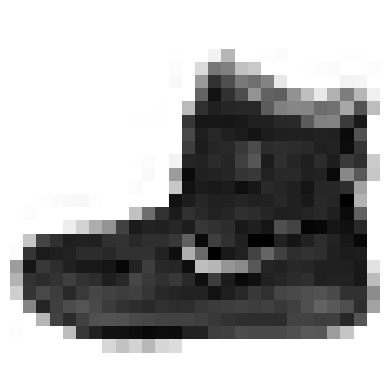

In [29]:
showImage(X_train[0])

In [30]:
y_train[0]

np.uint8(9)

4.Cleaning the data
    As part of data preparation, we need to perform following techniques on the data:

    1.Shuffling

    2.Feature Scaling

    Shuffling the training dataset - to get uniform samples for cross validation

    We need to shuffle our training data to ensure that we don't miss out any article (fashion product) in a cross validation fold.

    Feature Scaling

    Each image (instance) in the dataset has 784 pixels (features) and value of each feature(pixel) ranges from 0 to 255, and this range is too wide , hence we would need to use feature scaling here to apply standardization to this dataset X_train, so that all the values of each feature (pixel) is in a small range (based on the standard deviation value).

In [31]:
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

6.Training several models and analyzing their performance to select a model
As the data preparation is over, let us now train a few Machine Learning(ML) models.

    We will be training the following ML models:

    Softmax Regression (multi-class LogisticRegression)

    RandomForestClassifier

    Ensemble (with soft voting)

Softmax Regression (multi-class LogisticRegression)
    Let us now train the Softmax Regression (Logistic Regression - multi_class-multinomial). We will be doing the following as part of this exercise:

        1.We will be first training the Softmax Regression (Logistic Regression - multi_class-multinomial) on the training dataset
        2.Using the trained model, make the prediction on a sample instance and compare the prediction with the actual value.
        3.Using the trained model, make the prediction on the whole training dataset
        4.Calculate - accuracy, precision, recall and F1 Score for Softmax Regression (Logistic Regression - multi_class-multinomial).

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


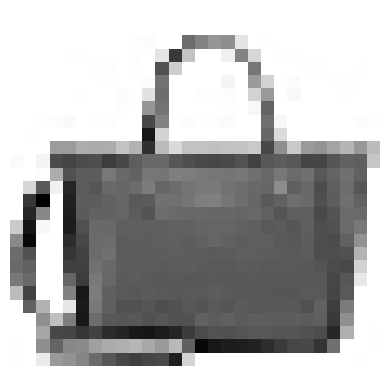

Logistic Accuracy:  0.87755
Logistic Precision:  0.8766648092442357
Logistic Recall:  0.87755
Logistic F1 Score:  0.8769448048542856


In [33]:
from sklearn.linear_model import LogisticRegression

# using Softmax Regression (multi-class classification problem)
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
# 'C' is hyprparameter for regularizing L2
# 'lbfgs' is Byoden-Fletcher-Goldfarb-Shanno(BFGS) algorithm
log_clf.fit(X_train_scaled, y_train)

# Let us predict some instance from the dataset using the above trained model
y_train_predict = log_clf.predict(X_train[0].reshape(1, -1))

y_train[0]

#Let us see the predicted class

y_train_predict[0]

showImage(X_train[0])

# Let us predict all instances of training dataset X_train_scaled using the above trained model
y_train_predict = log_clf.predict(X_train_scaled)

log_accuracy = accuracy_score(y_train, y_train_predict)
log_precision = precision_score(y_train, y_train_predict, average='weighted')
log_recall = recall_score(y_train, y_train_predict, average='weighted')
log_f1_score = f1_score(y_train, y_train_predict, average='weighted')


print("Logistic Accuracy: ", log_accuracy)
print("Logistic Precision: ", log_precision)
print("Logistic Recall: ", log_recall)
print("Logistic F1 Score: ", log_f1_score)

RandomForestClassifier
    Let us now train the RandomForestClassifier. We will be doing the following as part of this exercise:

        1.We will be first training the RandomForestClassifier on the training dataset
        2.Using the trained model, make the prediction on a sample instance and compare the prediction with the actual value.
        3.Using the trained model, make the prediction on the whole training dataset
        4.Calculate - accuracy, precision, recall and F1 Score for RandomForestClassifier.

8
8


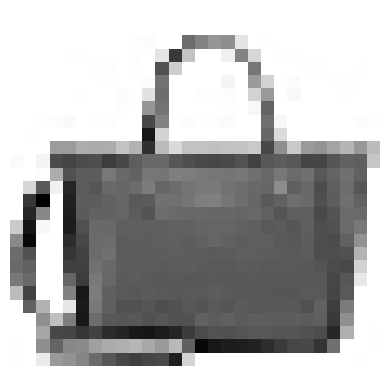

Logistic Accuracy:  0.8766666666666667
Logistic Precision:  0.8784075869648036
Logistic Recall:  0.8766666666666667
Logistic F1 Score:  0.875054729413325


In [34]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)

# Scaling is not needed for Decision Tree based algorithms like Random Forest and XGBoost
rnd_clf.fit(X_train, y_train)
y_train_predict = rnd_clf.predict(X_train[0].reshape(1, -1))
print(y_train[0] )

print(y_train_predict[0])

showImage(X_train[0])
y_train_predict = rnd_clf.predict(X_train)
rnd_accuracy = accuracy_score(y_train, y_train_predict)
rnd_precision = precision_score(y_train, y_train_predict, average='weighted')
rnd_recall = recall_score(y_train, y_train_predict, average='weighted')
rnd_f1_score = f1_score(y_train, y_train_predict, average='weighted')


print("Logistic Accuracy: ", rnd_accuracy)
print("Logistic Precision: ", rnd_precision)
print("Logistic Recall: ", rnd_recall)
print("Logistic F1 Score: ", rnd_f1_score)

Cross-Validation - Softmax Regression
    Let us import some libraries and define a function (display_scores()) which we will be using for cross-validation.

    We will be performing k-fold cross-validation with 3 folds (cv=3) on the Softmax Regression model, and calculating the mean accuracy, precision, recall and F1 score values for the same.

In [35]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
def display_scores(scores):
    print(scores.mean())
    print(scores.std())
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10 ,random_state=42)
log_cv_scores = cross_val_score(log_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")
display_scores(log_cv_scores)
log_cv_accuracy = log_cv_scores.mean()
y_train_pred = cross_val_predict(log_clf,X_train_scaled,y_train,cv=3)
confusion_matrix(y_train, y_train_pred)
log_cv_precision = precision_score(y_train, y_train_pred, average='weighted')
log_cv_recall = recall_score(y_train, y_train_pred, average='weighted')
log_cv_f1_score = f1_score(y_train, y_train_pred, average='weighted')

print("Logistic Precision: ", log_cv_precision)
print("Logistic Recall: ", log_recall)
print("Logistic F1 Score: ", log_cv_f1_score)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

0.8470833333333333
0.0022395436042987695


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

Logistic Precision:  0.8458694883855286
Logistic Recall:  0.87755
Logistic F1 Score:  0.846272242627941


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Validation - RandomForestClassifier
    We will be performing k-fold cross-validation with 3 folds (cv=3) on the RandomForestClassifier model, and calculating the mean accuracy, precision, recall and F1 score values for the same.

In [36]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
def display_scores(scores):
    print(scores.mean())
    print(scores.std())
rnd_clf = RandomForestClassifier(n_estimators=20, max_depth=10,random_state=42)
rnd_cv_scores = cross_val_score(rnd_clf,X_train,y_train,cv=3,scoring="accuracy")
display_scores(rnd_cv_scores)
rnd_cv_accuracy = rnd_cv_scores.mean()
y_train_pred = cross_val_predict(rnd_clf,X_train,y_train,cv=3)
confusion_matrix(y_train, y_train_pred)
rnd_cv_precision = precision_score(y_train, y_train_pred, average='weighted')
rnd_cv_recall = recall_score(y_train, y_train_pred, average='weighted')
rnd_cv_f1_score = f1_score(y_train, y_train_pred, average='weighted')

print("Logistic Precision: ", rnd_cv_precision)
print("Logistic Recall: ", rnd_recall)
print("Logistic F1 Score: ", rnd_cv_f1_score)

0.8482833333333334
0.002400462918318523
Logistic Precision:  0.8482875291253137
Logistic Recall:  0.8766666666666667
Logistic F1 Score:  0.8452574403288833


In [37]:
print("=== Softmax === ")
display_scores(log_cv_scores)
print("log_cv_accuracy:", log_cv_accuracy)
print("log_cv_precision:", log_cv_precision)
print("log_cv_recall:", log_cv_recall)
print("log_cv_f1_score:", log_cv_f1_score)

print("=== Random Forest === ")
display_scores(rnd_cv_scores)
print("rnd_cv_accuracy:", rnd_cv_accuracy)
print("rnd_cv_precision:", rnd_cv_precision)
print("rnd_cv_recall :", rnd_cv_recall )
print("rnd_cv_f1_score:", rnd_cv_f1_score)

=== Softmax === 
0.8470833333333333
0.0022395436042987695
log_cv_accuracy: 0.8470833333333333
log_cv_precision: 0.8458694883855286
log_cv_recall: 0.8470833333333333
log_cv_f1_score: 0.846272242627941
=== Random Forest === 
0.8482833333333334
0.002400462918318523
rnd_cv_accuracy: 0.8482833333333334
rnd_cv_precision: 0.8482875291253137
rnd_cv_recall : 0.8482833333333333
rnd_cv_f1_score: 0.8452574403288833


From the results of the cross-validation process, we see that both the logistic regression and random forest have given the best results (nearly accuracy - 85%, standard deviation for accuracy - 0.002, Precision, Recall, F1 score nearly 0.85).

Let us use Voting Classifier and proceed with the fine-tuning of the model (hyperparameters tuning).

7.Use dimensionality reduction to improve the ‘training’,‘fine-tuning’ and ‘prediction’ time.
    We will perform using 'Grid Search' technique.

    Grid search takes a lot of time on large datasets. Hence, let us apply 'Dimensionality Reduction' to the training dataset to reduce the number of features in the dataset, so that the time taken for grid search and prediction is reduced. Also, we will calculate the scores based on the reduced features.

    We will also check, if dimensionality reduction leads to any significant loss of information from the images in our training dataset. If we get a significant loss of information with dimensionality reduction, we will not use dimensionality reduction for our training dataset (and hence the problem).

    Our dataset is not like a Swiss-roll, therefore, we don't need to convert a 3-dimensional dataset to 2-dimensional plane, etc. Hence, we won't be using Manifold technique for dimensionality reduction here.

    We will be using Projection technique (PCA) for dimensionality reduction for our problem.

    We will use Scikit Learn's PCA class which uses SVD (Singular Value Decomposition) internally and also the projection.

    You can experiment with various values of n_components (variance ratio).

    For the current problem, with n_components=0.95, in the reduced dataset (X_train_reduced) we got only 187 features (out of original 784), and there was significant loss of information (quality) in the 'recovered' (decompressed) images. Hence, we have selected n_components=0.99, which gives 459 features (out of original 784) and there is no significant loss of information (quality) in the 'recovered' images.

    The comparison of the 'original' dataset images and the 'compressed' dataset images (got after decompression) shows that there is not much information loss due to dimensionality reduction by using 0.99 variance ratio. Hence, we will go ahead with performing the Grid Search using this 'reduced' training dataset (X_train_reduced).

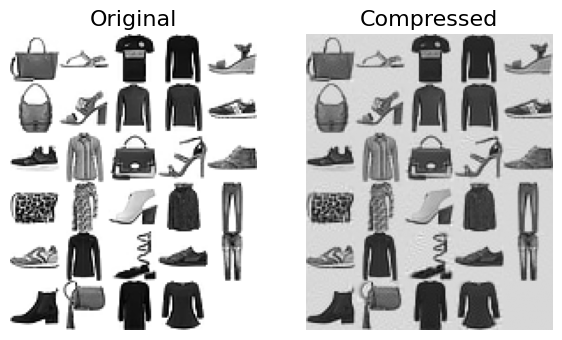

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train)
pca.n_components_

# Checking if hit your 99% minimum?
np.sum(pca.explained_variance_ratio_)

# use inverse_transform to decompress back to 784 dimensions

X_train_recovered = pca.inverse_transform(X_train_reduced)

import matplotlib
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
# Plotting 'original' image
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
# Plotting the corresponding 'recovered' image
plot_digits(X_train_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

8.Grid Search - Tuning Hyperparameters
    Let us now perform the Grid Search using the dimensionally reduced training dataset X_train_reduced.

    Since our best model is Voting Classifier which is made up of two models Logistic Regression and Random Forrest. To do the grid search, we will have to supply the various values of parameters for both of the underlying models.

    Since the grid search is a very intensive process, we are going to only try a handful of permutations because it would take a huge time otherwise.

In [39]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        "lr__multi_class":["multinomial"],
        "lr__solver":["lbfgs"],
        "lr__C":[5],
        "rf__n_estimators":[20],
        "rf__max_depth":[10,15],
    }]
log_clf_ens = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10 , random_state=42)
rnd_clf_ens = RandomForestClassifier(n_estimators=20, max_depth=10 , random_state=42)
voting_clf_grid_search = VotingClassifier(
    estimators=[('lr', log_clf_ens), ('rf', rnd_clf_ens)],
    voting='soft')
grid_search = GridSearchCV(voting_clf_grid_search, param_grid, cv=3 , scoring='neg_mean_squared_error')
grid_search.fit(X_train_reduced, y_train)
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

1.3803018993442462 {'lr__C': 5, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs', 'rf__max_depth': 10, 'rf__n_estimators': 20}
1.3662966978905668 {'lr__C': 5, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs', 'rf__max_depth': 15, 'rf__n_estimators': 20}


9.Evaluating Final Model on Test Dataset    
    Since, we already got our 'final' model from grid search (best_estimator_), let us evaluate the same on the test dataset.

    Since, we performed grid search on the dimensionally reduced training dataset X_train_reduced, we need to apply dimensionality reduction the the test dataset also before we could use it for prediction on the test dataset.

0.8485 0.8464118434708594 0.8485 0.8468394487543847
9
9


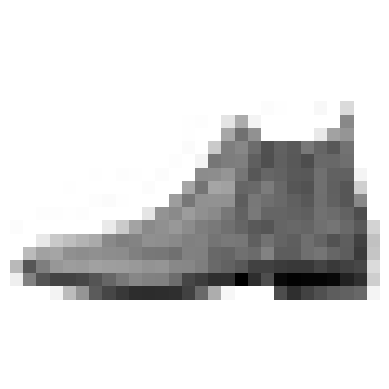

In [40]:
final_model = grid_search.best_estimator_
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
X_test_reduced = pca.transform(X_test)
y_test_predict = final_model.predict(X_test_reduced)
confusion_matrix(y_test, y_test_predict)
final_accuracy = accuracy_score(y_test, y_test_predict)
final_precision = precision_score(y_test, y_test_predict, average='weighted')
final_recall = recall_score(y_test, y_test_predict, average='weighted')
final_f1_score = f1_score(y_test, y_test_predict, average='weighted')
print(final_accuracy,final_precision,final_recall,final_f1_score,end="\n")
print(y_test[0])

print(y_test_predict[0])

showImage(X_test[0])

In [41]:
X_test_reduced=pca.transform(X_test)

In [42]:
len(X_test_reduced)

10000